---
title: Mauna Lua $CO_2$ forecasting using MLP
author: ["Hrriday V. Ruparel"]
date: "2024-03-13"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
image: "output.png"
categories: ["Neural Networks", "Forecasting"]

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Supported Device: {device}")

Supported Device: cpu


Loading the data

Mauna Lua CO2 Dataset - https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv

In [2]:
df = pd.read_csv('co2_mm_mlo.csv')
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
787,2023,10,2023.7917,418.82,422.12,27,0.47,0.17
788,2023,11,2023.8750,420.46,422.46,21,0.91,0.38
789,2023,12,2023.9583,421.86,422.58,20,0.68,0.29
790,2024,1,2024.0417,422.80,422.45,27,0.73,0.27


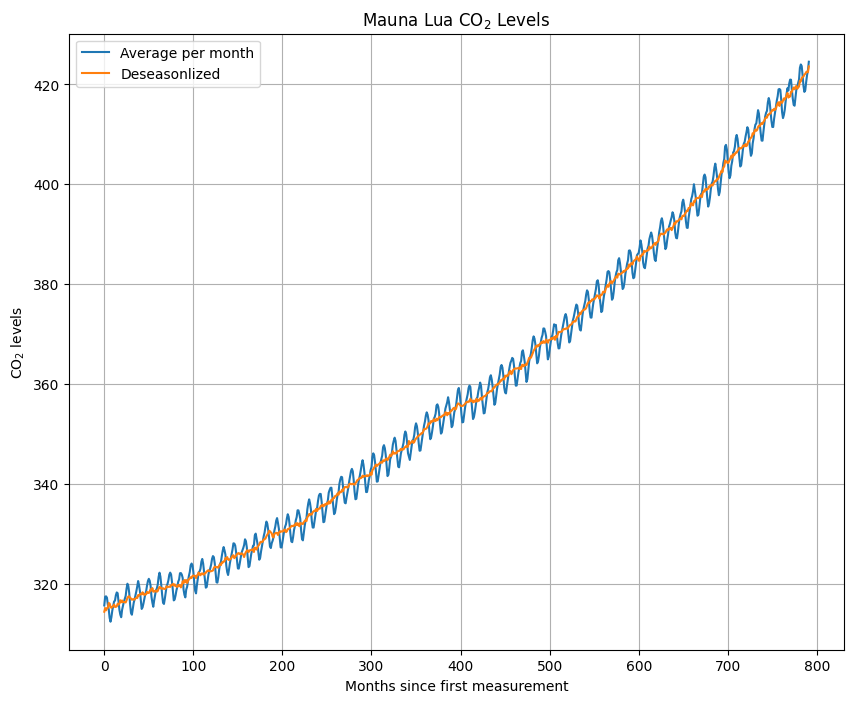

In [3]:
fig = plt.figure(figsize=(10,8))
plt.title(r'Mauna Lua CO$_2$ Levels')
plt.plot(df.index, df['average'])
plt.plot(df.index, df['deseasonalized'])
plt.xlabel('Months since first measurement')
plt.ylabel(r'CO$_2$ levels')
plt.grid()
plt.legend(['Average per month', 'Deseasonlized'])
plt.show()

Creating features

![Dataset](./data.png)
<br>L = Number of Samples
<br>K = Feature Window Size
<br>T = Label Window Size

In [ ]:
scaler = StandardScaler().fit(df['average'].values.reshape(-1,1))
scaled_D = scaler.transform(df['average'].values.reshape(-1,1))
scaled_D.shape, scaled_D

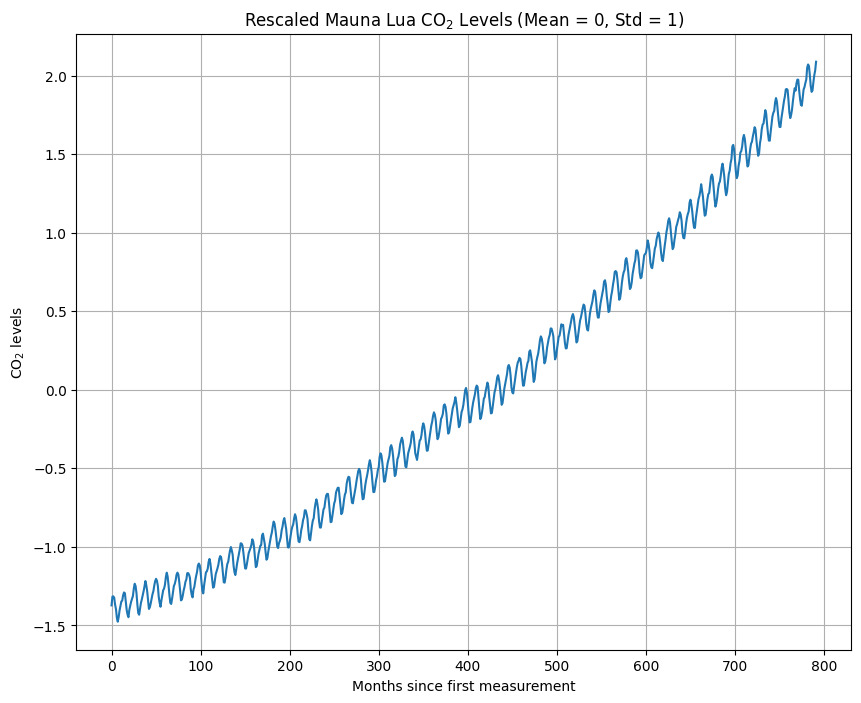

In [5]:
fig = plt.figure(figsize=(10,8))
plt.title(r'Rescaled Mauna Lua CO$_2$ Levels (Mean = 0, Std = 1)')
plt.plot(df.index, scaled_D)
plt.xlabel('Months since first measurement')
plt.ylabel(r'CO$_2$ levels')
plt.grid()
plt.show()

Generalized Code

In [6]:
class KTEstimator():
    def __init__(self, data:np.array = scaled_D, K = 3, T = 1, train_size:float = 0.80) -> None:
        self.K = K
        self.T = T
        self.istrained = False
        
        # Creating Feature - Label Matrix        
        D = np.zeros(shape=(len(data)-(self.K+self.T)+1, self.K+self.T))
        for i in range(D.shape[0]):
            D[i] = np.concatenate([data[i:i+self.K,0], data[i+self.K:i+self.K+self.T,0]])
        
        # Test Train Split
        X_train, X_test, y_train, y_test = D[:int(len(D)*train_size),:self.K], D[int(len(D)*train_size):,:self.K], D[:int(len(D)*train_size),self.K:self.K+self.T], D[int(len(D)*train_size):,self.K:self.K+self.T]
        X_train = torch.tensor(X_train,dtype = torch.float32, device = device, requires_grad=False)
        y_train = torch.tensor(y_train,dtype = torch.float32, device = device, requires_grad=False)
        X_test = torch.tensor(X_test,dtype = torch.float32, device = device, requires_grad=False)
        y_test = torch.tensor(y_test,dtype = torch.float32, device = device, requires_grad=False)

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        return None
    
    def fit(self, model, convergence:float = 1e-8, num_epochs:int = 2000, batch_size:int = 32, lr:float = 0.001):

        # Training the model
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr = lr)
        print_every = 100

        dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []

        for epoch in range(num_epochs):
            l = 0
            for data, target in train_dataloader:
                opt.zero_grad()
                y_pred = model(data)
                loss = loss_fn(y_pred, target.reshape(-1,self.T))
                l += loss.item()
                loss.backward()
                opt.step()
            
            losses.append(l/len(self.X_train))

            if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
                print(f'Final Training Loss: {losses[-1]}')
                print(f'Converged after {epoch} epochs')
                break

            if epoch % print_every == 0:
                print(f"Epoch: {epoch} | Loss: {losses[-1]}")
        
        self.train_loss = losses
        self.istrained = True
        return None
    
    def predict(self, model, seed:int = 42, num_test_cases:int = 5, cumulative:bool = False, pred_len:int = 10):
        loss_fn = nn.MSELoss()
        np.random.seed(seed)

        if self.istrained == False:
            # Untrained Model Prediction
            if cumulative == False:
                with torch.no_grad():
                    test_indices = np.random.randint(0, len(self.X_test), size = num_test_cases)
                    for i in test_indices:
                        y = model(self.X_test[i])
                        loss = loss_fn(y, self.y_test[i])
                        plt.title(f'Extrapolation\nUntrained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
                        plt.plot(np.arange(i+len(self.X_train),i+len(self.X_train)+self.K,1), self.X_test[i], 'bo-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), self.y_test[i].detach().numpy(), 'go-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), y.detach().numpy(), 'ro-')
                        plt.legend(['Input','Ground Truth','Predicted'])
                        plt.xlabel('Months since first measurement')
                        plt.ylabel(r'Normalized CO$_2$ levels')
                        plt.grid()
                        plt.show()
            else:
                if self.K + pred_len > len(self.X_test):
                    print(f'Sum of input feature length: {self.K} and output predicted length {pred_len} greater test size: {len(self.X_test)}')
                else:
                    test_index = np.random.randint(0, len(self.X_test)-(self.K+pred_len))
                    y = torch.zeros(pred_len, dtype=torch.float32, device=device, requires_grad=False)
                    for i in range(pred_len):
                        if i <  self.K:
                            y[i] = model(torch.concat((self.X_test[test_index+i, 0:self.K-i], y[0:i])))
                        elif i >= self.K:
                            y[i] = model(y[i-self.K:i])
                        else:
                            y[i] = model(self.X_test[test_index+i, 0:self.K])
                    loss = loss_fn(y.view(-1,1), self.y_test[test_index: test_index + pred_len])
                    plt.title(f'Cumulative Extrapolation\nUntrained Model Prediction on Test Data\nTest Index: {test_index} | MSE: {loss}')
                    plt.plot(np.arange(test_index+len(self.X_train),test_index+len(self.X_train)+self.K,1), self.X_test[test_index], 'bo-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), self.y_test[test_index:test_index + pred_len].detach().numpy(), 'go-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), y.detach().numpy(), 'ro-')
                    plt.legend(['Input','Ground Truth','Predicted'])
                    plt.xlabel('Months since first measurement')
                    plt.ylabel(r'Normalized CO$_2$ levels')
                    plt.grid()
                    plt.show()
        else:
            # Trained Model Prediction
            if cumulative == False:
                with torch.no_grad():
                    test_indices = np.random.randint(0, len(self.X_test), size = num_test_cases)
                    for i in test_indices:
                        y = model(self.X_test[i])
                        loss = loss_fn(y, self.y_test[i])
                        plt.title(f'Extrapolation\nTrained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
                        plt.plot(np.arange(i+len(self.X_train),i+len(self.X_train)+self.K,1), self.X_test[i], 'bo-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), self.y_test[i].detach().numpy(), 'go-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), y.detach().numpy(), 'ro-')
                        plt.legend(['Input','Ground Truth','Predicted'])
                        plt.xlabel('Months since first measurement')
                        plt.ylabel(r'Normalized CO$_2$ levels')
                        plt.grid()
                        plt.show()
            else:
                if self.K + pred_len > len(self.X_test):
                    print(f'Sum of input feature length: {self.K} and output predicted length {pred_len} greater test size: {len(self.X_test)}')
                else:
                    test_index = np.random.randint(0, len(self.X_test)-(self.K+pred_len))
                    y = torch.zeros(pred_len, dtype=torch.float32, device=device, requires_grad=False)
                    for i in range(pred_len):
                        if i <  self.K:
                            y[i] = model(torch.concat((self.X_test[test_index+i, 0:self.K-i], y[0:i])))
                        elif i >= self.K:
                            y[i] = model(y[i-self.K:i])
                        else:
                            y[i] = model(self.X_test[test_index+i, 0:self.K])
                    loss = loss_fn(y.view(-1,1), self.y_test[test_index:test_index + pred_len])
                    plt.title(f'Cumulative Extrapolation\nTrained Model Prediction on Test Data\nTest Index: {test_index} | MSE: {loss}')
                    plt.plot(np.arange(test_index+len(self.X_train),test_index+len(self.X_train)+self.K,1), self.X_test[test_index], 'bo-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), self.y_test[test_index:test_index + pred_len].detach().numpy(), 'go-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), y.detach().numpy(), 'ro-')
                    plt.legend(['Input','Ground Truth','Predicted'])
                    plt.xlabel('Months since first measurement')
                    plt.ylabel(r'Normalized CO$_2$ levels')
                    plt.grid()
                    plt.show()
                    return test_index
        return None

Multilayer Perceptron

In [7]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_size1, hidden_size2, output_dim):
    super(MLP, self).__init__()
    self.lin1 = nn.Linear(input_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, output_dim)

  def forward(self, x):
    y1 = self.lin1(x)
    y2 = torch.relu(y1)
    y3 = self.lin2(y2)
    y4 = torch.relu(y3)
    y = self.lin3(y4)
    return y

Extrapolation (Given K, predict the next T)

In [195]:
K = 30
T = 10

hidden_size1 = 20
hidden_size2 = 15

model = MLP(input_dim = K, hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, output_dim = T)

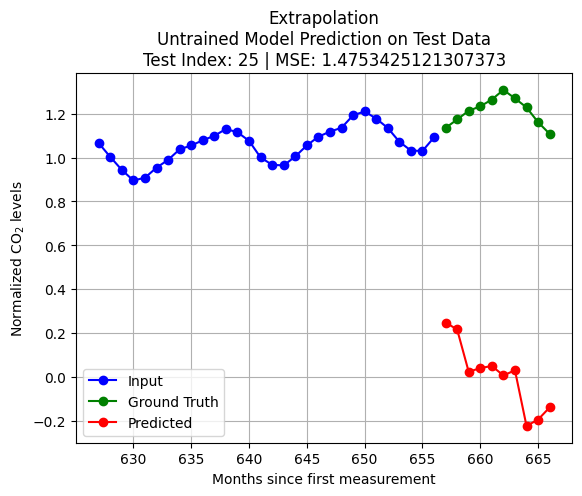

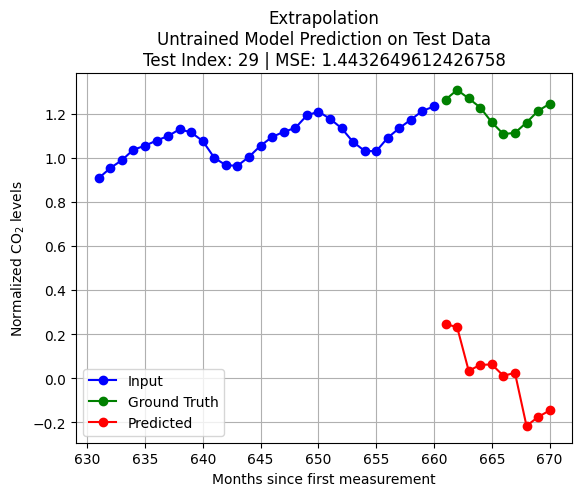

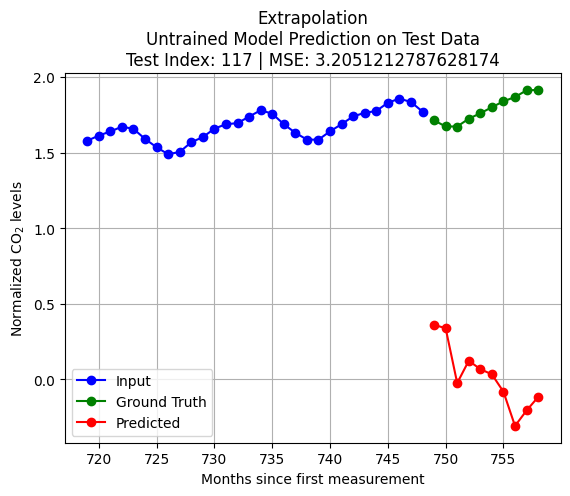

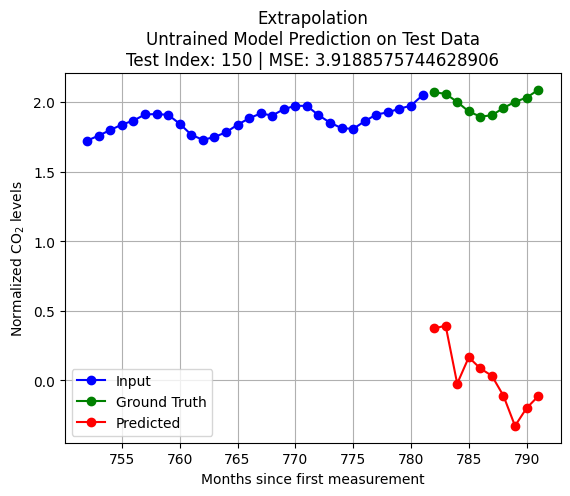

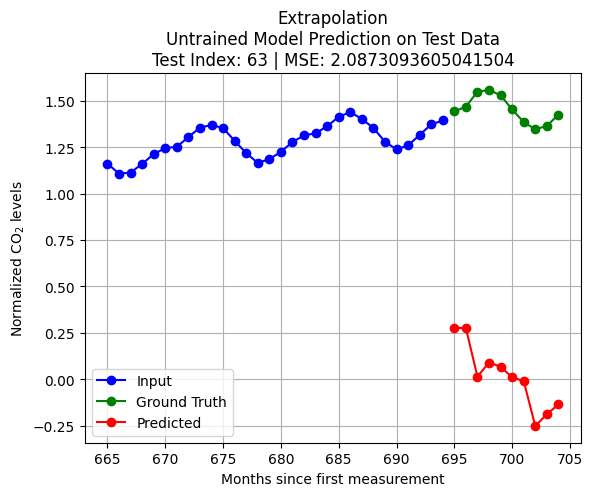

Epoch: 0 | Loss: 0.007182229409285162
Epoch: 100 | Loss: 1.3296213639169882e-05
Final Training Loss: 1.2681912128006007e-05
Converged after 111 epochs


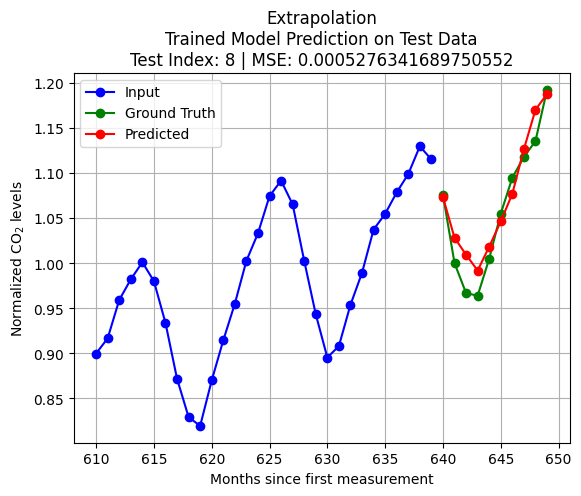

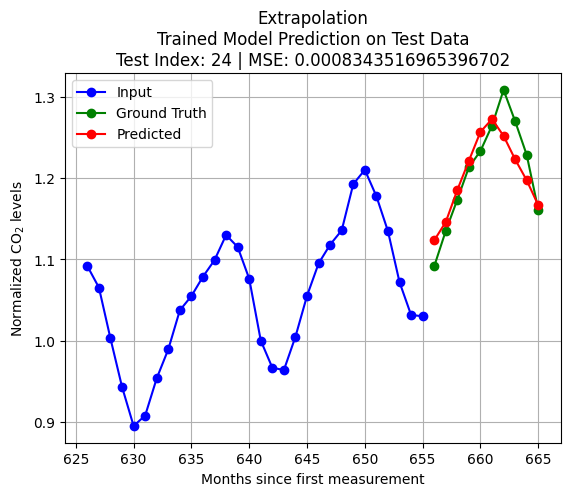

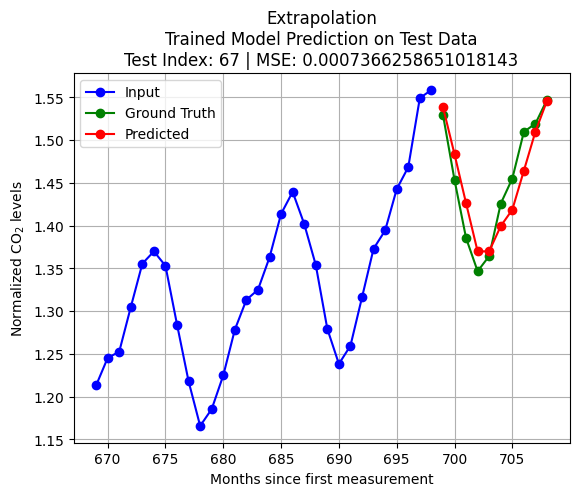

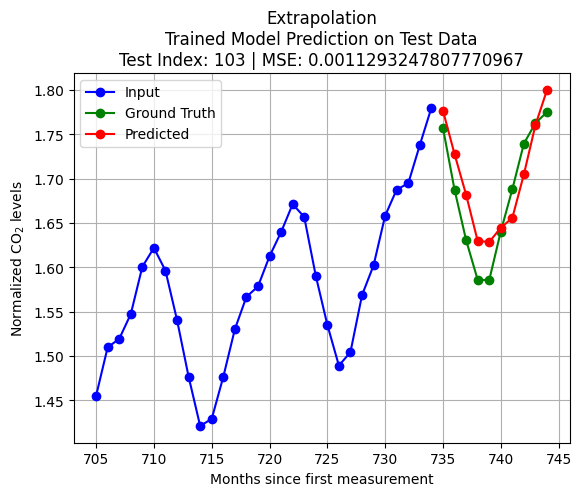

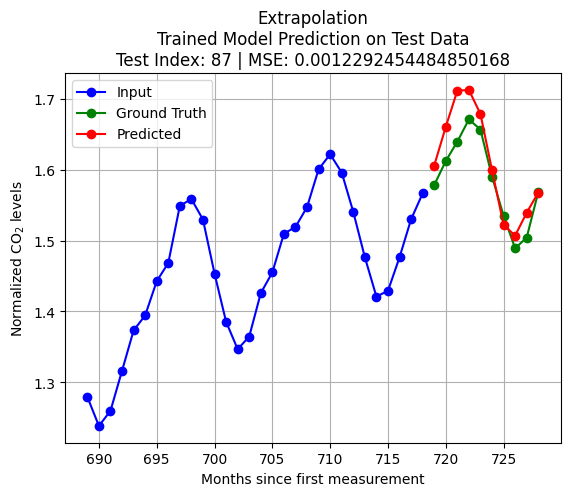

In [196]:
train_size = 0.8
est = KTEstimator(scaled_D, K, T, train_size)
seed = 53
num_test_cases = 5

# Untrained Model Prediction
est.predict(model, seed, num_test_cases, cumulative = False)


convergence = 1e-8
num_epochs = 2000
batch_size = 32
lr = 0.01
#Trained Model Prediction
est.fit(model, convergence, num_epochs, batch_size, lr)
est.predict(model, 100, 5, cumulative  = False)

Cumulative Extrapolation (Given K, predict the next T cumulatively, keep using newer predicted values for further prediction)

In [197]:
K = 30
T = 1
hidden_size1 = 20
hidden_size2 = 15

model = MLP(input_dim = K, hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, output_dim = T)

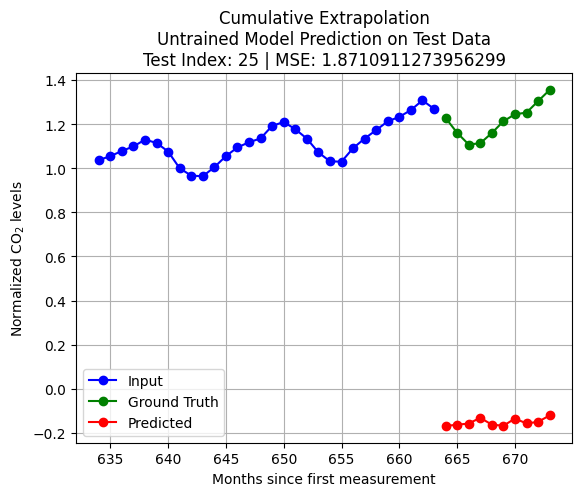

Epoch: 0 | Loss: 0.003588407486983023
Epoch: 100 | Loss: 7.710569678294994e-06
Epoch: 200 | Loss: 7.126164914306231e-06
Epoch: 300 | Loss: 5.075917952650105e-06
Epoch: 400 | Loss: 1.303993873925167e-05
Final Training Loss: 5.368270272999231e-06
Converged after 449 epochs


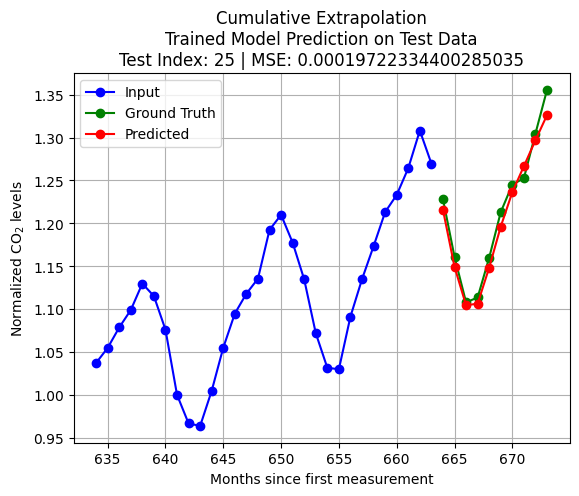

In [198]:
train_size = 0.8
est2 = KTEstimator(scaled_D, K, T, train_size)
seed = 53
pred_len = 10

# Untrained Model Prediction
est2.predict(model, seed, cumulative = True, pred_len = pred_len)

convergence = 1e-8
num_epochs = 2000
batch_size = 32
lr = 0.01
# Trained Model Prediction
est2.fit(model, convergence, num_epochs, batch_size, lr)
test_index = est2.predict(model, seed, cumulative = True, pred_len = pred_len)

Reconstructing test set

In [22]:
class KTEstimator():
    def __init__(self, data:np.array = scaled_D, K = 3, T = 1, train_size:float = 0.80) -> None:
        self.K = K
        self.T = T
        self.istrained = False
        
        # Creating Feature - Label Matrix        
        D = np.zeros(shape=(len(data)-(self.K+self.T)+1, self.K+self.T))
        for i in range(D.shape[0]):
            D[i] = np.concatenate([data[i:i+self.K,0], data[i+self.K:i+self.K+self.T,0]])
        
        # Test Train Split
        X_train, X_test, y_train, y_test = D[:int(len(D)*train_size),:self.K], D[int(len(D)*train_size):,:self.K], D[:int(len(D)*train_size),self.K:self.K+self.T], D[int(len(D)*train_size):,self.K:self.K+self.T]
        X_train = torch.tensor(X_train,dtype = torch.float32, device = device, requires_grad=False)
        y_train = torch.tensor(y_train,dtype = torch.float32, device = device, requires_grad=False)
        X_test = torch.tensor(X_test,dtype = torch.float32, device = device, requires_grad=False)
        y_test = torch.tensor(y_test,dtype = torch.float32, device = device, requires_grad=False)

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        return None
    
    def fit(self, model, convergence:float = 1e-8, num_epochs:int = 2000, batch_size:int = 32, lr:float = 0.001):

        # Training the model
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr = lr)
        print_every = 100

        dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []

        for epoch in range(num_epochs):
            l = 0
            for data, target in train_dataloader:
                opt.zero_grad()
                y_pred = model(data)
                loss = loss_fn(y_pred, target.reshape(-1,self.T))
                l += loss.item()
                loss.backward()
                opt.step()
            
            losses.append(l/len(self.X_train))

            if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
                print(f'Final Training Loss: {losses[-1]}')
                print(f'Converged after {epoch} epochs')
                break

            if epoch % print_every == 0:
                print(f"Epoch: {epoch} | Loss: {losses[-1]}")
        
        self.train_loss = losses
        self.istrained = True
        return None
    
    def predict(self, model, seed:int = 42, num_test_cases:int = 5, cumulative:bool = False, pred_len:int = 10):
        loss_fn = nn.MSELoss()
        np.random.seed(seed)

        if self.istrained == False:
            # Untrained Model Prediction
            if cumulative == False:
                with torch.no_grad():
                    test_indices = np.random.randint(0, len(self.X_test), size = num_test_cases)
                    for i in test_indices:
                        y = model(self.X_test[i])
                        loss = loss_fn(y, self.y_test[i])
                        plt.title(f'Extrapolation\nUntrained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
                        plt.plot(np.arange(i+len(self.X_train),i+len(self.X_train)+self.K,1), self.X_test[i], 'bo-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), self.y_test[i].detach().numpy(), 'go-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), y.detach().numpy(), 'ro-')
                        plt.legend(['Input','Ground Truth','Predicted'])
                        plt.xlabel('Months since first measurement')
                        plt.ylabel(r'Normalized CO$_2$ levels')
                        plt.grid()
                        plt.show()
            else:
                if self.K + pred_len > len(self.X_test):
                    print(f'Sum of input feature length: {self.K} and output predicted length {pred_len} greater test size: {len(self.X_test)}')
                else:
                    test_index = seed
                    y = torch.zeros(pred_len, dtype=torch.float32, device=device, requires_grad=False)
                    for i in range(pred_len):
                        if i <  self.K:
                            y[i] = model(torch.concat((self.X_test[test_index+i, 0:self.K-i], y[0:i])))
                        elif i >= self.K:
                            y[i] = model(y[i-self.K:i])
                        else:
                            y[i] = model(self.X_test[test_index+i, 0:self.K])
                    loss = loss_fn(y.view(-1,1), self.y_test[test_index: test_index + pred_len])
                    plt.title(f'Cumulative Extrapolation\nUntrained Model Prediction on Test Data\nTest Index: {test_index} | MSE: {loss}')
                    plt.plot(np.arange(test_index+len(self.X_train),test_index+len(self.X_train)+self.K,1), self.X_test[test_index], 'bo-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), self.y_test[test_index:test_index + pred_len].detach().numpy(), 'go-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), y.detach().numpy(), 'ro-')
                    plt.legend(['Input','Ground Truth','Predicted'])
                    plt.xlabel('Months since first measurement')
                    plt.ylabel(r'Normalized CO$_2$ levels')
                    plt.grid()
                    plt.show()
        else:
            # Trained Model Prediction
            if cumulative == False:
                with torch.no_grad():
                    test_indices = np.random.randint(0, len(self.X_test), size = num_test_cases)
                    for i in test_indices:
                        y = model(self.X_test[i])
                        loss = loss_fn(y, self.y_test[i])
                        plt.title(f'Extrapolation\nTrained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
                        plt.plot(np.arange(i+len(self.X_train),i+len(self.X_train)+self.K,1), self.X_test[i], 'bo-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), self.y_test[i].detach().numpy(), 'go-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), y.detach().numpy(), 'ro-')
                        plt.legend(['Input','Ground Truth','Predicted'])
                        plt.xlabel('Months since first measurement')
                        plt.ylabel(r'Normalized CO$_2$ levels')
                        plt.grid()
                        plt.show()
            else:
                if self.K + pred_len > len(self.X_test):
                    print(f'Sum of input feature length: {self.K} and output predicted length {pred_len} greater test size: {len(self.X_test)}')
                else:
                    test_index = seed
                    y = torch.zeros(pred_len, dtype=torch.float32, device=device, requires_grad=False)
                    for i in range(pred_len):
                        if i <  self.K:
                            y[i] = model(torch.concat((self.X_test[test_index+i, 0:self.K-i], y[0:i])))
                        elif i >= self.K:
                            y[i] = model(y[i-self.K:i])
                        else:
                            y[i] = model(self.X_test[test_index+i, 0:self.K])
                    loss = loss_fn(y.view(-1,1), self.y_test[test_index:test_index + pred_len])
                    plt.title(f'Cumulative Extrapolation\nTrained Model Prediction on Test Data\nTest Index: {test_index} | MSE: {loss}')
                    plt.plot(np.arange(test_index+len(self.X_train),test_index+len(self.X_train)+self.K,1), self.X_test[test_index], 'bo-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), self.y_test[test_index:test_index + pred_len].detach().numpy(), 'go-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), y.detach().numpy(), 'ro-')
                    plt.legend(['Input','Ground Truth','Predicted'])
                    plt.xlabel('Months since first measurement')
                    plt.ylabel(r'Normalized CO$_2$ levels')
                    plt.grid()
                    plt.show()
                    return test_index
        return None

In [23]:
K = 30
T = 1
hidden_size1 = 20
hidden_size2 = 15

model = MLP(input_dim = K, hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, output_dim = T)

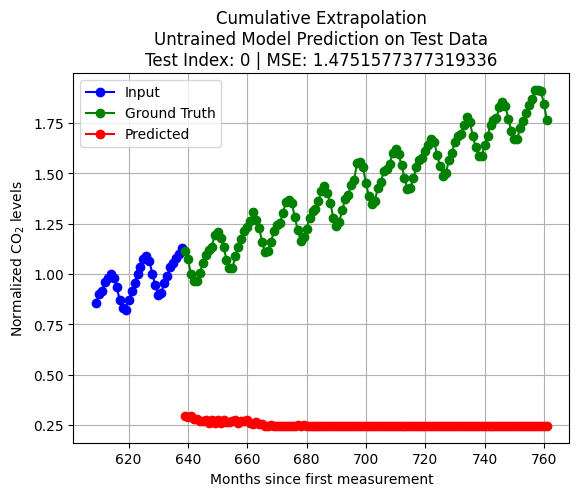

Epoch: 0 | Loss: 0.004901672210521409
Epoch: 100 | Loss: 8.292564985473077e-06
Epoch: 200 | Loss: 1.4769373398426345e-05
Epoch: 300 | Loss: 1.5116783194163622e-05
Epoch: 400 | Loss: 6.656706106542397e-06
Epoch: 500 | Loss: 1.286951828511334e-05
Epoch: 600 | Loss: 9.617879626967493e-06
Epoch: 700 | Loss: 1.196309566229799e-05
Final Training Loss: 5.322310881027449e-06
Converged after 754 epochs


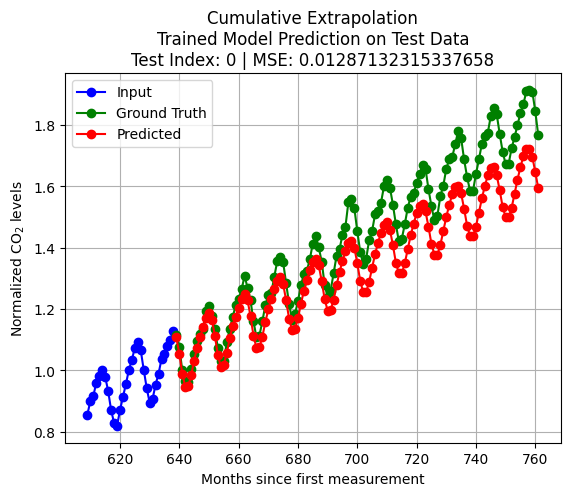

In [24]:
train_size = 0.8
est2 = KTEstimator(scaled_D, K, T, train_size)
seed = 0
pred_len = 123

# Untrained Model Prediction
est2.predict(model, seed, cumulative = True, pred_len = pred_len)

convergence = 1e-8
num_epochs = 2000
batch_size = 32
lr = 0.01
# Trained Model Prediction
est2.fit(model, convergence, num_epochs, batch_size, lr)
test_index = est2.predict(model, seed, cumulative = True, pred_len = pred_len)

MA (Moving Average) and ARMA (Auto Regressive Moving Average)

f:\D\Python\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\D\Python\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


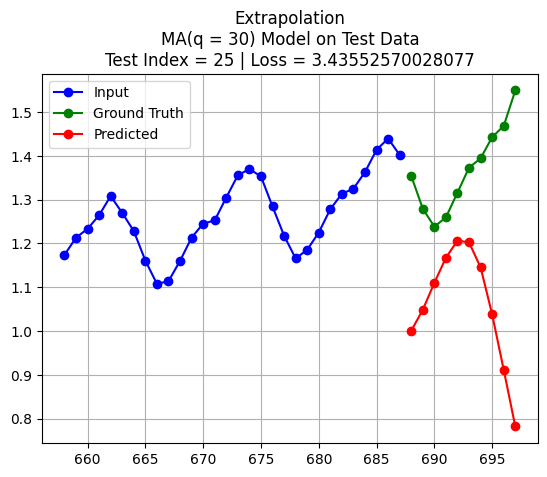

In [199]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

X_train = pd.Series(scaled_D[:int(len(scaled_D)*train_size)].reshape(-1,))
X_test = pd.Series(scaled_D[int(len(scaled_D)*train_size)+test_index:int(len(scaled_D)*train_size)+K+test_index].reshape(-1,))
q = K


model = ARIMA(X_train, order=(0, 0, q)) # (autoregressive = 0, differencing = 0, moving average = q)
model_fit = model.fit()
forecast = model_fit.forecast(steps=pred_len)
y_test = scaled_D[int(len(scaled_D)*train_size)+K+test_index:int(len(scaled_D)*train_size)+K+pred_len+test_index]
loss = np.linalg.norm(y_test - forecast.to_numpy(),2)


plt.plot(np.arange(int(len(scaled_D)*train_size)+test_index,int(len(scaled_D)*train_size)+test_index+K,1),X_test, 'bo-')
plt.title(f'Extrapolation\nMA(q = {q}) Model on Test Data\nTest Index = {test_index} | Loss = {loss}')
plt.plot(np.arange(int(len(scaled_D)*train_size)+test_index+K,int(len(scaled_D)*train_size)+test_index+K+pred_len,1),y_test, 'go-')
plt.plot(np.arange(int(len(scaled_D)*train_size)+test_index+K,int(len(scaled_D)*train_size)+test_index+K+pred_len,1),forecast, 'ro-')
plt.legend(['Input', 'Ground Truth', 'Predicted'])
plt.grid()
plt.show()

f:\D\Python\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\D\Python\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\D\Python\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


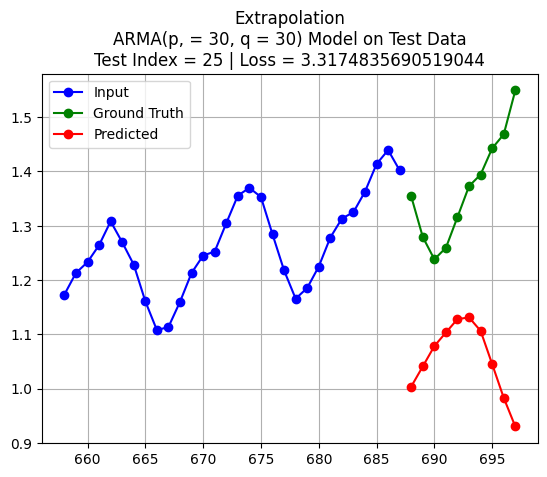

In [200]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

X_train = pd.Series(scaled_D[:int(len(scaled_D)*train_size)].reshape(-1,))
X_test = pd.Series(scaled_D[int(len(scaled_D)*train_size)+test_index:int(len(scaled_D)*train_size)+K+test_index].reshape(-1,))
q = K
p = K

model = ARIMA(X_train, order=(p, 0, q)) # (autoregressive = p, differencing = 0, moving average = q)
model_fit = model.fit()
forecast = model_fit.forecast(steps=pred_len)
y_test = scaled_D[int(len(scaled_D)*train_size)+K+test_index:int(len(scaled_D)*train_size)+K+pred_len+test_index]
loss = np.linalg.norm(y_test - forecast.to_numpy(),2)


plt.plot(np.arange(int(len(scaled_D)*train_size)+test_index,int(len(scaled_D)*train_size)+test_index+K,1),X_test, 'bo-')
plt.title(f'Extrapolation\nARMA(p, = {p}, q = {q}) Model on Test Data\nTest Index = {test_index} | Loss = {loss}')
plt.plot(np.arange(int(len(scaled_D)*train_size)+test_index+K,int(len(scaled_D)*train_size)+test_index+K+pred_len,1),y_test, 'go-')
plt.plot(np.arange(int(len(scaled_D)*train_size)+test_index+K,int(len(scaled_D)*train_size)+test_index+K+pred_len,1),forecast, 'ro-')
plt.legend(['Input', 'Ground Truth', 'Predicted'])
plt.grid()
plt.show()